# Accelerated Time Failure Model

In [33]:
import numpy as np
import pandas as pd
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
import os

In [34]:
# Obtener la ruta absoluta del directorio actual (donde está el script o notebook)
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subimos un nivel

# Construir la ruta relativa a la carpeta "Datos"
ruta_bdd = os.path.join(base_dir, "Datos", "database.xlsx")


In [35]:
data = pd.read_excel(ruta_bdd, sheet_name=None)

In [36]:
# Concatenamos los dataframes de cada key:
data = pd.concat(data.values(), ignore_index=True)
print(data.shape)
data.head()

(52, 15)


,FECHA,Caudal,TPH,% Solido,Presion,Bateria,Ciclón,Medicion,horometro,camino_id,uso_230,dias_230,score,score_out,E
0,2019-03-18,3547.089913,4431.989958,70.141037,9.738540,BHC 1011,CyA,240.0,17987.828125,1011 CyA_2018-09-03,2365.541992,196,9.856425,0,1
1,2024-08-18,5618.364990,4718.561523,59.569263,10.484711,BHC 1011,CyB,233.5,50149.431641,1011 CyB_2024-07-31,148.064453,18,0.634109,0,0
2,2017-11-07,3569.976555,4801.625823,69.654428,9.867432,BHC 1011,CyF,235.0,13588.043945,1011 CyF_2017-09-12,1195.004883,56,5.085127,0,0
3,2020-06-15,3665.670568,4105.001673,69.657474,9.777703,BHC 1011,CyG,240.0,25063.132812,1011 CyG_2019-10-08,3748.732422,251,15.619718,0,1
4,2024-09-10,4974.534010,4812.063802,63.132505,7.701962,BHC 1011,CyG,232.5,49058.373047,1011 CyG_2024-07-31,466.740234,41,2.007485,0,0


## Implementación AFT

Primero verificaremos que la distribución distinta de censuras sea (o no) aleatoria:

In [38]:
data["E"].value_counts()

E
0    28
1    24
Name: count, dtype: int64

In [39]:
from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(data[data["E"] == 1]["dias_230"], data[data["E"] == 0]["E"])
print(f"Estadístico KS: {ks_stat:.4f}, p-valor: {p_value:.4f}")

if p_value < 0.05:
    print("Las distribuciones de censurados y no censurados son significativamente diferentes.")
else:
    print("No hay evidencia suficiente para afirmar que las distribuciones sean diferentes.")


Estadístico KS: 1.0000, p-valor: 0.0000
Las distribuciones de censurados y no censurados son significativamente diferentes.


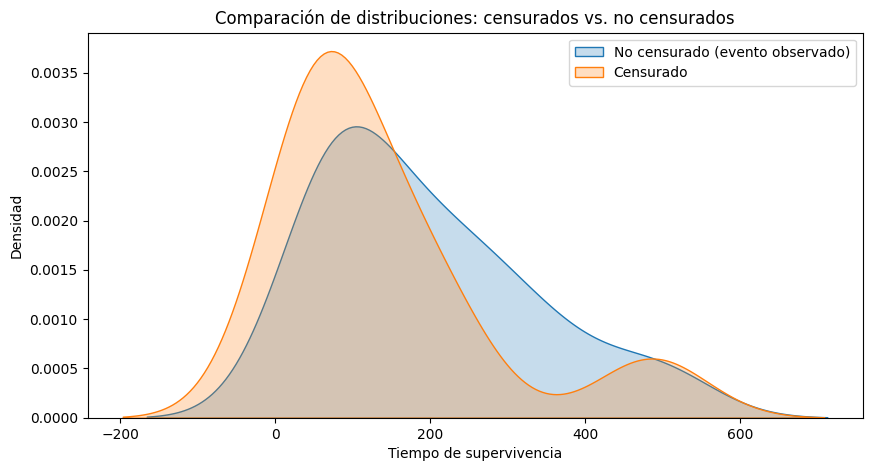

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.kdeplot(data[data["E"] == 1]["dias_230"], label="No censurado (evento observado)", fill=True)
sns.kdeplot(data[data["E"] == 0]["dias_230"], label="Censurado", fill=True)
plt.xlabel("Tiempo de supervivencia")
plt.ylabel("Densidad")
plt.title("Comparación de distribuciones: censurados vs. no censurados")
plt.legend()
plt.show()


## Medium

In [41]:
from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()
# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = data["dias_230"], event_observed = data["E"])
    # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 326.5984775187825
The AIC value for ExponentialFitter is 331.9517102064151
The AIC value for LogNormalFitter is 323.7643430298748
The AIC value for LogLogisticFitter is 325.78366959263116


In [42]:
from lifelines import LogNormalAFTFitter
lognorm_aft = LogNormalAFTFitter()
lognorm_aft.fit(data, duration_col='dias_230', event_col='E', formula="Caudal + TPH + `% Solido` + Presion")
lognorm_aft.print_summary(3)

<lifelines.LogNormalAFTFitter: fitted with 52 total observations, 28 right-censored observations>
             duration col = 'dias_230'
                event col = 'E'
   number of observations = 52
number of events observed = 24
           log-likelihood = -159.324
         time fit was run = 2025-02-19 18:15:18 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                   
mu_    Intercept  8.923  7500.117    10.320         -11.304          29.149               0.000           4.564e+12
       Caudal     0.000     1.000     0.000          -0.000           0.001               1.000               1.001
       TPH        0.000     1.000     0.001          -0.001           0.002               0.999               1.002
       % Solido   0.014     1.014     0.016          -0.018           0.046               0.982               1.047
       Presion   -0.575     0.563     1.021          -2.577           1.426               0.076               4.162
sigma_ Intercept -0.229     0.795     0.141          -0.506           0.047               0.603               1.048

                  cmp to      z     p  -log2(p)
param  covariate                               
mu_    Intercept   0.000  0.865 0.387     1.369
       Caudal      0.000  0.099 0.921     0.119
       TPH         0.000  0.343 0.732     0.451
       % Solido    0.000  0.841 0.400     1.321
       Presion     0.000 -0.563 0.573     0.803
sigma_ Intercept   0.000 -1.627 0.104     3.269
---
Concordance = 0.570
AIC = 330.648
log-likelihood ratio test = 1.116 on 4 df
-log2(p) of ll-ratio test = 0.165

In [43]:
print(lognorm_aft.median_survival_time_)
print(lognorm_aft.mean_survival_time_)

233.73958157662958
320.600131419715
